In [2]:
### Set CUDA device
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [3]:
from typing import List, Dict, Union
import numpy as np
import torch
from torch import Tensor, nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import sys
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from torchvision.transforms import GaussianBlur
from torchmetrics.functional.classification import dice

from torchmetrics.classification import BinaryPrecisionRecallCurve
from sklearn.metrics import auc

## Augmentations
from batchgenerators.transforms.noise_transforms import augment_gaussian_blur

sys.path.append('../')
from data_utils import get_eval_data
from model.unet import get_unet
from utils import  epoch_average, UMapGenerator
from model.mahalanobis_adatper import (
    get_pooling_mahalanobis_detector, 
    get_batchnorm_mahalanobis_detector
)
from model.wrapper import PoolingMahalanobisWrapper, BatchNormMahalanobisWrapper


from matplotlib.colors import ListedColormap, Normalize

def format_e(n):
    a = '%e' % n
    return a.split('e')[0].rstrip('0').rstrip('.') + 'e' + a.split('e')[1]


# Create a custom colormap - transparent for class 0, and different colors for other classes
seg_colors = ['none', 'yellow', 'green', 'blue']  # 'none' for transparent
err_colors = ['none', 'red']
seg_cmap = ListedColormap(seg_colors)
err_cmap = ListedColormap(err_colors)

# Ensure the colormap is normalized to the number of classes
seg_norm = Normalize(vmin=0, vmax=len(seg_colors)-1)
err_norm = Normalize(vmin=0, vmax=len(err_colors)-1)



nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [4]:
### Load basic config
cfg = OmegaConf.load('../configs/basic_config_venusberg.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

In [5]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-16-4-8
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr


unet_name = 'default-8'
postfix = '_no-blurring'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name + postfix
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = int(args[1])

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])


unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=False,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda()

In [6]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = False

# update config with default values
OmegaConf.update(
    cfg, 
    'eval',
    OmegaConf.load('../configs/eval/unet_config.yaml')
)

# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = False
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = [] #'all'


data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)

dataloader = DataLoader(data['train'], 
    batch_size=32, 
    shuffle=False, 
    drop_last=False
)

print(f'\nAvailable datasets are: {list(data.keys())}')

loading dataset
loading all case properties

Available datasets are: ['train']


In [7]:

class DomainshiftAugmenter(nn.Module):
    def __init__(
            self, 
            augments: List[nn.Module],
            return_original: bool = False
        ):
        super(DomainshiftAugmenter, self).__init__()
        self.augments = augments
        self.return_original = return_original
    
    def forward(self, x: Tensor):
        if self.return_original:
            return [x] + [aug(x) for aug in self.augments]
        else:
            return [aug(x) for aug in self.augments]
    

def get_gaussian_domainshift_augments(
    sigmas: List[float],
    truncate: float = 4.0,
) -> List[nn.Module]:
    # radius = round(truncate * sigma)
    # kernel_size = 2*radius + 1

    return [
        GaussianBlur(
            kernel_size= 2 * round( truncate * sigma ) + 1,
            sigma=sigma
        ) for sigma in sigmas
    ]


def get_precision_recall_for_domainshift_flips(
    model: nn.Module, 
    dataset: Dataset, 
    net_out: str, 
    umap: str,
    domain_shift_aug: nn.Module,
    sequential: bool = False,
    n_taus: Union[str, int] = 'auto',
    device=['cuda:0', 'cpu']
):
    model.eval()
    
    batch_size = 32

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        drop_last=True
    )

    umap_generator = UMapGenerator(
        method=umap,
        net_out=net_out,
    ).cpu() #.to(device[0])

    umaps   = []
    errmaps = []

    for _, batch in enumerate(dataloader):

        input_ = batch['input'].to(device[0])
        input_augmented = domain_shift_aug(input_)

        model.set_transform(False)
        output_id = model(input_).cpu()
        output_ood = model(input_augmented).cpu()
        model.set_transform(True)
        output_ood_transformed = model(input_augmented)

        if net_out == 'brain':
            segmap_id = (torch.sigmoid(output_id) > 0.5) * 1
            segmap_ood = (torch.sigmoid(output_ood) > 0.5) * 1
        elif net_out == 'heart':
            segmap_id = torch.argmax(output_id, dim=1, keepdims=True)
            segmap_ood = torch.argmax(output_ood, dim=1, keepdims=True)
        errmap = (segmap_id != segmap_ood).float()

        if sequential:
            umap_aggregate = 0
            for output_chunk in output_ood_transformed:
                umap_aggregate += umap_generator(
                    torch.cat([output_ood, output_chunk], dim=0).cpu(), 
                    batch_size=batch_size
                ).cpu()

            umaps.append(umap_aggregate)

        else:
            umaps.append(
                umap_generator(
                    torch.cat([output_ood, output_ood_transformed], dim=0).cpu(), 
                    batch_size=batch_size
                ).cpu()
            )
        errmaps.append(errmap.cpu())

    umaps = torch.cat(umaps, dim=0).flatten() * 1000
    umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())
    errmaps = torch.cat(errmaps, dim=0).flatten().to(torch.uint8)

    # in case of manual threshold selection
    if n_taus != 'auto':
        # taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)**(1/16)).tolist()
        taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)).tolist()
    elif n_taus == 'auto':
        taus = None

    # TODO: Change to torcheval once its stable :)
    # bprc = torcheval.metrics.BinaryPrecisionRecallCurve()
    bprc = BinaryPrecisionRecallCurve(thresholds = taus).to(device[1])
    pr = bprc(umaps.to(device[1]), errmaps.to(device[1]))
    if device[1] != 'cpu':
        pr = tuple(map(lambda x: x.cpu(), pr))

    pr_auc = auc(pr[1], pr[0])

    # subset precision/recall to 100 points for plotting
    # we find indices along the x axis (recall) such that they
    # have roughly equal distance to each other and select the 
    # corresponding y values (precision)
    p, r, _= pr  
    # find indices for sorting in recall
    indices = np.argsort(r)
    # sort precision and recall similarly
    r_sorted, p_sorted = (r[indices], p[indices])
    # select target values for recall
    target_values = np.linspace(r_sorted[0], r_sorted[-1], 100)
    # find best matches in sorted recall, that are smaller or equal to the target values
    subset_indices = np.abs(r_sorted[None, :] - target_values[:, None]).argmin(axis=1)
    # select precision and recall at the best matches
    r_sampled, p_sampled = (
        r_sorted[subset_indices], 
        p_sorted[subset_indices]
    )

    return p_sampled, r_sampled, pr_auc



@torch.no_grad()
def get_precision_recall_for_domainshift_flips_model(
    model: nn.Module, 
    dataset: Dataset, 
    net_out: str, 
    dae: bool,
    umap: str,
    domain_shift_aug: nn.Module,
    n_taus: Union[str, int] = 'auto',
    device=['cuda:0', 'cpu']
):
    if dae == True:
        # Remove trainiung hooks, add evaluation hooks
        model.remove_all_hooks()        
        model.hook_inference_transformations(model.transformations, n_samples=1)
        # Put model in evaluation state
        model.to(device[0])
        model.freeze_seg_model()
    model.eval()
    
    batch_size = 32

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        drop_last=True
    )

    umap_generator = UMapGenerator(
        method=umap,
        net_out=net_out,
    ).to(device[0])

    umaps   = []
    errmaps = []

    for _, batch in enumerate(dataloader):

        input_ = batch['input'].to(device[0])
        input_augmented = domain_shift_aug(input_)

        output_id = model(input_)
        output_ood = model(input_augmented)

        if net_out == 'brain':
            segmap_id = (torch.sigmoid(output_id) > 0.5) * 1
            segmap_ood = (torch.sigmoid(output_ood) > 0.5) * 1
            errmap = (segmap_id != segmap_ood).float()
        elif net_out == 'heart':
            segmap_id = torch.argmax(output_id, dim=1, keepdims=True)
            segmap_ood = torch.argmax(output_ood, dim=1, keepdims=True)
            errmap = (segmap_id != segmap_ood).float()
        umaps.append(
            umap_generator(
                output_ood,
                batch_size=batch_size
            ).cpu()
        )
        errmaps.append(errmap.cpu())

    umaps = torch.cat(umaps, dim=0).flatten()
    umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())
    errmaps = torch.cat(errmaps, dim=0).flatten().to(torch.uint8)

    # in case of manual threshold selection
    if n_taus != 'auto':
        # taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)**(1/16)).tolist()
        taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)).tolist()
    elif n_taus == 'auto':
        taus = None

    # TODO: Change to torcheval once its stable :)
    # bprc = torcheval.metrics.BinaryPrecisionRecallCurve()
    bprc = BinaryPrecisionRecallCurve(thresholds = taus).to(device[1])
    pr = bprc(umaps.to(device[1]), errmaps.to(device[1]))
    if device[1] != 'cpu':
        pr = tuple(map(lambda x: x.cpu(), pr))

    pr_auc = auc(pr[1], pr[0])

    # subset precision/recall to 100 points for plotting
    # we find indices along the x axis (recall) such that they
    # have roughly equal distance to each other and select the 
    # corresponding y values (precision)
    p, r, _= pr  
    # find indices for sorting in recall
    indices = np.argsort(r)
    # sort precision and recall similarly
    r_sorted, p_sorted = (r[indices], p[indices])
    # select target values for recall
    target_values = np.linspace(r_sorted[0], r_sorted[-1], 100)
    # find best matches in sorted recall, that are smaller or equal to the target values
    subset_indices = np.abs(r_sorted[None, :] - target_values[:, None]).argmin(axis=1)
    # select precision and recall at the best matches
    r_sampled, p_sampled = (
        r_sorted[subset_indices], 
        p_sorted[subset_indices]
    )

    return p_sampled, r_sampled, pr_auc

In [8]:
augments = get_gaussian_domainshift_augments(
    sigmas = [0.5 * i for i in range(1, 7)]
)

augmenter = DomainshiftAugmenter(augments=augments, return_original=True)

In [9]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]
sequential = False


detector = get_pooling_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    pool='none',
    sigma_algorithm='diagonal',
    fit='raw',
    dist_fn='squared_mahalanobis',
    iid_data=dataloader,
    transform=True,
    lr=1e-1,
    sequential=sequential,
    device='cuda:0'
)



In [17]:
detector.sequential = False

In [78]:
detector.set_lr(2e-1)

In [20]:
    
for lr in [1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1, 8e-1, 9e-1, 1e0]:
    detector.set_lr(lr)
    p_sampled, r_sampled, pr_auc = get_precision_recall_for_domainshift_flips(
            model=detector,
            dataset=data['train'],
            net_out='heart',
            umap='cross_entropy',
            domain_shift_aug=augments[4],
            sequential=False,
            n_taus='auto',
            device=['cuda:0', 'cpu']
        )
    print(f'AUC: {pr_auc}')

AUC: 0.4455769956111908
AUC: 0.40092945098876953
AUC: 0.35185810923576355
AUC: 0.29933449625968933
AUC: 0.22028835117816925
AUC: 0.1391233503818512
AUC: 0.09211206436157227
AUC: 0.0648968443274498
AUC: 0.048533711582422256
AUC: 0.03814278542995453


In [15]:
detector.set_lr(3e-1)
for aug in augments:
    
    p_sampled, r_sampled, pr_auc = get_precision_recall_for_domainshift_flips(
            model=detector,
            dataset=data['train'],
            net_out='heart',
            umap='diff_grad',
            domain_shift_aug=aug,
            sequential=True,
            n_taus='auto',
            device=['cuda:0', 'cpu']
        )
    print(f'FlipSteps: Sigma={aug.sigma[1]} - AUPRC={pr_auc}')

    p_sampled, r_sampled, pr_auc = get_precision_recall_for_domainshift_flips_model(
        model=unet,
        dataset=data['train'],
        net_out='heart',
        umap='entropy',
        dae=False,
        domain_shift_aug=aug,
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(f'Entropy: Sigma={aug.sigma[1]} - AUPRC={pr_auc}\n')

FlipSteps: Sigma=0.5 - AUPRC=0.043521467596292496
Entropy: Sigma=0.5 - AUPRC=0.20284391939640045

FlipSteps: Sigma=1.0 - AUPRC=0.1511382758617401
Entropy: Sigma=1.0 - AUPRC=0.32276296615600586

FlipSteps: Sigma=1.5 - AUPRC=0.23330964148044586
Entropy: Sigma=1.5 - AUPRC=0.3571787476539612

FlipSteps: Sigma=2.0 - AUPRC=0.33190709352493286
Entropy: Sigma=2.0 - AUPRC=0.38798075914382935

FlipSteps: Sigma=2.5 - AUPRC=0.4143434762954712
Entropy: Sigma=2.5 - AUPRC=0.4055823087692261

FlipSteps: Sigma=3.0 - AUPRC=0.4733777344226837
Entropy: Sigma=3.0 - AUPRC=0.4246922731399536



Current Best:
Sequential, 5e-4, squared mahalanobis - 0.3648959100246429  
Sequential, 1e-3, squared mahalanobis - 0.3685983419418335  
Sequential, 1e-2, squared mahalanobis - 0.3693641126155853  
Sequential, 1e-1, squared mahalanobis - 0.3932522535324096  
Sequential, 2e-1, squared mahalanobis - 0.4089385271072387  
Sequential, 3e-1, squared mahalanobis - 0.4126993417739868  
Sequential, 4e-1, squared mahalanobis - 0.4074587225914001  
Sequential, 5e-1, squared mahalanobis - 0.3981633484363556  
Non-Sequential, 1e-1, squared mahalanobis - 0.31989818811416626


with Sequential, 3e-1, squared mahalanobis:
FlipSteps: Sigma=0.5 - AUPRC=0.043521467596292496
Entropy: Sigma=0.5 - AUPRC=0.20284391939640045
FlipSteps: Sigma=1.0 - AUPRC=0.1511382758617401
Entropy: Sigma=1.0 - AUPRC=0.32276296615600586
FlipSteps: Sigma=1.5 - AUPRC=0.23330964148044586
Entropy: Sigma=1.5 - AUPRC=0.3571787476539612
FlipSteps: Sigma=2.0 - AUPRC=0.33190709352493286
Entropy: Sigma=2.0 - AUPRC=0.38798075914382935
FlipSteps: Sigma=2.5 - AUPRC=0.4143434762954712
Entropy: Sigma=2.5 - AUPRC=0.4055823087692261
FlipSteps: Sigma=3.0 - AUPRC=0.4733777344226837
Entropy: Sigma=3.0 - AUPRC=0.4246922731399536


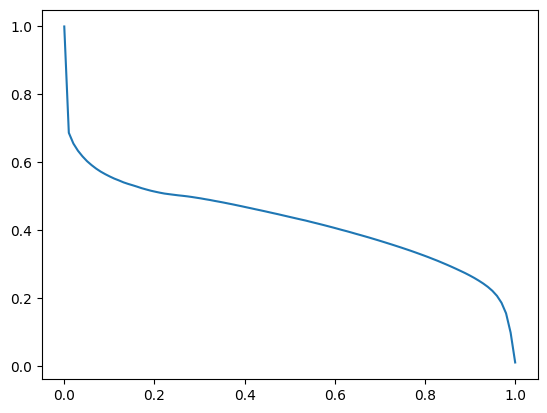

In [16]:
plt.plot(r_sampled, p_sampled)

In [34]:
p_sampled, r_sampled, pr_auc = get_precision_recall_for_domainshift_flips_model(
    model=unet,
    dataset=data['train'],
    net_out='heart',
    umap='entropy',
    dae=False,
    domain_shift_aug=augments[4],
    n_taus='auto',
    device=['cuda:0', 'cpu']
)

In [35]:
pr_auc

0.40558314323425293

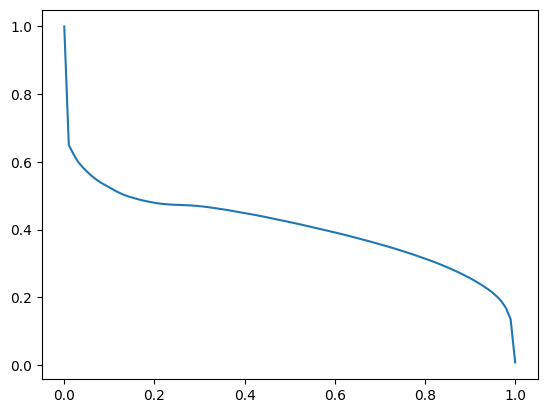

In [36]:
plt.plot(r_sampled, p_sampled)